<a href="https://colab.research.google.com/github/agonist11/colabadmixtools/blob/main/Test_ColabADMIXTOOLS_V4_8a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ColabADMIXTOOLS Version 4.8a**
This notebook is designed to make it easier for people to model themselves (or just the AADR) using ADMIXTOOLS (which includes qpAdm) with curated datasets. This notebook uses the AADR dataset from [here](https://reich.hms.harvard.edu/allen-ancient-dna-resource-aadr-downloadable-genotypes-present-day-and-ancient-dna-data).

You will need a Google account to be able to use Google Colaboratory. If you recieved this as a link, please make a copy for yourself using the **'File'** tab. If you received this a .ipynb, upload this notebook using the **'File'** tab.

Once the notebook is loaded, click **Connect** (top-right) to connect to a hosted runtime. CPU option should work fine. We will be borrowing storage and a CPU from Google. As a result, nothing will be saved once you disconnect from the session. However, you may use the Colab File Explorer (left sidebar under security key) to view, open, and download intermediate or final results.

# **[1] Install Software**

In [ ]:
import os
from subprocess import run, PIPE

# @markdown **Select your preferences for the setup process**

# @markdown Do you want to install ADMIXTOOLS?
install_admixtools = True  # @param {type:"boolean"}

# @markdown Do you want to install ADMIXTOOLS2? (This will increase setup time.)
install_admixtools2 = True  # @param {type:"boolean"}

# Function to check if a command exists
def command_exists(command):
    return run(['which', command], stdout=PIPE, stderr=PIPE).returncode == 0

# Install R if not already installed
if not command_exists('R'):
    print("Installing R...")
    !sudo apt-get update -y
    !sudo apt-get install -y r-base
else:
    print("R is already installed.")

# Install rpy2 if not already installed
try:
    import rpy2
    print("rpy2 is already installed.")
except ImportError:
    print("Installing rpy2...")
    !pip install rpy2

# Load the rpy2 extension for Python
%load_ext rpy2.ipython

# Check for PLINK
if not os.path.exists('/content/plink'):
    print("Installing PLINK (latest stable version)...")
    !wget https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20241022.zip -O plink.zip
    !unzip -o plink.zip -d /content/
    os.remove("plink.zip")
    print("PLINK installation complete!")
else:
    print("PLINK is already installed.")

# Check and install ADMIXTOOLS
if install_admixtools:
    if not os.path.exists('/content/AdmixTools'):
        print("Installing ADMIXTOOLS...")
        !apt-get update
        !apt-get install -y build-essential libgsl-dev libopenblas-dev gfortran liblapacke-dev \
                           libssl-dev libffi-dev libncurses5-dev zlib1g zlib1g-dev \
                           libreadline-dev libbz2-dev libsqlite3-dev
        !rm -rf AdmixTools
        !git clone https://github.com/DReichLab/AdmixTools.git
        %cd AdmixTools/src
        !sed -i "s/-Wimplicit/-Wimplicit -fcommon/" Makefile
        !make clobber
        !make all LDLIBS="-llapacke -llapack -lgsl -lopenblas -lm -lnick"
        !make install
        %cd /content/
        print("ADMIXTOOLS installation complete!")
    else:
        print("ADMIXTOOLS is already installed.")

# Check and install ADMIXTOOLS2
if install_admixtools2:
    try:
        import rpy2.robjects as ro
        print("Checking for ADMIXTOOLS2 installation...")
        ro.r('''
        if (!requireNamespace("admixtools", quietly = TRUE)) {
            stop("ADMIXTOOLS2 is not installed.")
        }
        ''')
        print("ADMIXTOOLS2 is already installed.")
    except Exception as e:
        print("Installing ADMIXTOOLS2...")
        ro.r('''
        lib_path <- "/usr/local/lib/R/site-library"
        install.packages("remotes", lib = lib_path)
        remotes::install_github("uqrmaie1/admixtools", dependencies = TRUE, lib = lib_path)
        ''')
        print("ADMIXTOOLS2 installation complete!")

print("Setup complete!")


**Both PLINK and rpy2 will be installed in any scenario. ADMIXTOOLS (AT1) installation is faster but model computation is slower. AT2 installation is slower but model computation is faster. We recommend exploration and rotation strategy with AT2 and double-checking with AT1 afterwards.**

# **[2] Your DNA File Upload**

**If you only want to model samples within the AADR you may skip this section and move to [3] Dataset Selection.**

In [ ]:
# @title Option 1: Upload 23andMe Raw Data (If you have AncestryDNA Raw Data, skip to Option 2)
from google.colab import files

uploaded = files.upload()

# Assuming the user will upload only one genome file, you can check if a file has been uploaded successfully.
if uploaded:
    filename = next(iter(uploaded))
    print(f"File '{filename}' uploaded successfully.")
else:
    print("No file uploaded.")

**23andMe formatted data works best for conversion. Please explore [DNA Kit Studio](https://www.dnagenics.com/dna-kit-studio/) on how to make this conversion possible. Some users have also found success with [this](https://tendna.com/en/dna-converter) converter as well.**

In [ ]:
# @title Option 2: Upload and Convert AncestryDNA to 23andMe Raw Data Format
from google.colab import files
import os

def convert_ancestry_to_23andme(ancestry_content):
    # Split content into lines and filter out the header and comments
    lines = ancestry_content.strip().split("\n")
    # Find the header end index and skip the header
    header_end_idx = next(i for i, line in enumerate(lines) if line.startswith("rsid"))
    data_lines = lines[header_end_idx+1:]  # Skip header row

    # Convert AncestryDNA format to 23andMe format with commented header
    converted_lines = ["# rsid\tchromosome\tposition\tgenotype"]
    for line in data_lines:
        parts = line.split("\t")
        if len(parts) == 5:  # Ensure line has 5 columns
            rsid, chromosome, position, allele1, allele2 = parts
            genotype = allele1 + allele2
            converted_lines.append(f"{rsid}\t{chromosome}\t{position}\t{genotype}")

    return "\n".join(converted_lines)

# @markdown Choose if you want to upload a new file or use an existing file:
file_option = "Use Existing File"  # @param ["Upload New File", "Use Existing File"]
# @markdown If using an existing file, please provide the file path:
existing_file_path = "/content/AncestryDNArawrtest4.txt"  # @param {type:"string"}

if file_option == "Upload New File":
    uploaded = files.upload()
    # Check if a file has been uploaded successfully.
    if uploaded:
        filename = next(iter(uploaded))
        content = uploaded[filename].decode("utf-8")

        # Check if the uploaded file is in AncestryDNA format
        if "AncestryDNA raw data download" in content:
            print(f"Converting '{filename}' from AncestryDNA to 23andMe format...")
            converted_content = convert_ancestry_to_23andme(content)
            converted_filename = filename.replace(".txt", "_converted.txt")

            # Saving the converted file into the current folder
            with open(converted_filename, "w") as f:
                f.write(converted_content)
            print(f"File converted and saved as '{converted_filename}' in the current folder.")
        else:
            print(f"File '{filename}' does not appear to be in AncestryDNA format.")
    else:
        print("No file uploaded.")

elif file_option == "Use Existing File":
    if os.path.exists(existing_file_path):
        with open(existing_file_path, "r") as f:
            content = f.read()

        # Check if the file is in AncestryDNA format
        if "AncestryDNA raw data download" in content:
            print(f"Converting '{existing_file_path}' from AncestryDNA to 23andMe format...")
            converted_content = convert_ancestry_to_23andme(content)
            converted_filename = existing_file_path.replace(".txt", "_converted.txt")

            # Saving the converted file into the current folder
            with open(converted_filename, "w") as f:
                f.write(converted_content)
            print(f"File converted and saved as '{converted_filename}' in the current folder.")
        else:
            print(f"File '{existing_file_path}' does not appear to be in AncestryDNA format.")
    else:
        print(f"File '{existing_file_path}' does not exist.")


In [ ]:
# @title Option 3: Mount Google Drive and Unzip Folder Previous Files (Returning Users)
# @markdown Enter the path to your zip folder and run this cell to mount your Google Drive. If you previously ran Step 7 of this notebook, the zipped folder path will usually look like "/content/drive/MyDrive/colabadmixtools/examplefolder.zip"
zip_folder_path = "" #@param {type:"string"}

from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Full path to the zip file
zip_file_path = os.path.join('/content/drive/MyDrive/', zip_folder_path)

# Check if the zip file exists
if os.path.exists(zip_file_path) and zip_file_path.endswith('.zip'):
    # Unzipping the contents to /content folder
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('/content/')
        print(f"Contents of '{zip_folder_path}' have been extracted to '/content/'")
else:
    print(f"Zip file not found at '{zip_folder_path}'. Please ensure the path is correct and includes the zip folder name.")



In [ ]:
# @title Optional Step: Mount Google Drive and Upload SNP Lists
# @markdown Enter the path to the folder containing your SNP lists and run this cell to mount your Google Drive.
# @markdown The folder path will usually look like "/content/drive/MyDrive/yourfolder/"
snp_list_folder_path = "/content/drive/MyDrive/colabadmixtools/snplists" #@param {type:"string"}

from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Check if the folder exists
if os.path.exists(snp_list_folder_path) and os.path.isdir(snp_list_folder_path):
    # Destination folder in Colab
    destination_folder = '/content/snplist_files'
    os.makedirs(destination_folder, exist_ok=True)

    # Copying the contents to the destination folder
    for item in os.listdir(snp_list_folder_path):
        source = os.path.join(snp_list_folder_path, item)
        destination = os.path.join(destination_folder, item)
        if os.path.isfile(source):
            shutil.copy2(source, destination)
        elif os.path.isdir(source):
            shutil.copytree(source, destination, dirs_exist_ok=True)

    print(f"Contents of '{snp_list_folder_path}' have been copied to '{destination_folder}'")
else:
    print(f"Folder not found at '{snp_list_folder_path}'. Please ensure the path is correct and includes the folder name.")


**If you do not have the snplists, modeling your sample can lead to high Standard Errors. Please ask whoever sent you this notebook to provide you the snplists. Then use the Optional Step above if it is in your Google Drive or manually upload them to this session using the Upload function on the left.**

In [ ]:
#@markdown ### [Experimental] DNA File Conversion to 23andMe Format
#@markdown **Specify your DNA file path and configure the settings below.**

import os

# Set up terraseq
def setup_terraseq():
    terraseq_url = "https://github.com/enelsr/terraseq/releases/latest/download/terraseq"
    os.system(f"wget -O terraseq {terraseq_url}")
    os.system("chmod +x terraseq")
    print("terraseq setup completed successfully.")

#@markdown **Specify the file path of your DNA file:**
input_file = "/content/MyHeritage_raw_dna_data.csv"  #@param {type:"string"}

#@markdown **Select the input file format:**
input_format = "myheritage"  #@param ["23andme", "ancestry", "myheritage", "ftdnav1", "ftdnav2"]

#@markdown **Specify the output file name:**
output_file = "converted_23andme.txt"  #@param {type:"string"}

# Convert the DNA file
def convert_dna_file():
    if not os.path.exists(input_file):
        print(f"Error: The file path '{input_file}' does not exist. Please check the file path and re-run the cell.")
        return

    print(f"Converting {input_file} from {input_format} to 23andMe format...")
    try:
        command = f"./terraseq convert --inFile {input_file} --inFormat {input_format} --outFormat 23andme --outFile {output_file}"
        os.system(command)

        if os.path.exists(output_file):
            print(f"Conversion successful! Output file: {output_file}")
        else:
            print("Conversion failed. Please check your input file and format.")
    except Exception as e:
        print(f"Error during conversion: {e}")

# Ensure terraseq is set up
setup_terraseq()

# Perform the conversion
convert_dna_file()


# **[3] Dataset Selection**

**The 1240K has more coverage than the 1240K+HO. However, the 1240K+HO has more modern samples. You can download one after the other if you would like to explore both datasets.**

In [ ]:
# @title Download 1240K or HO Datasets (AADR v62)
# @markdown Select the dataset you want to download:

dataset_choice = "1240K+HO" #@param ["1240K", "1240K+HO"]

# Define the URLs and corresponding filenames for each dataset
dataset_files = {
    "1240K": [
        ("https://dataverse.harvard.edu/api/access/datafile/10537413", "aadr_v62.0_1240K_public.anno"),
        ("https://dataverse.harvard.edu/api/access/datafile/10537126", "aadr_v62.0_1240K_public.geno"),
        ("https://dataverse.harvard.edu/api/access/datafile/10537414", "aadr_v62.0_1240K_public.ind"),
        ("https://dataverse.harvard.edu/api/access/datafile/10537415", "aadr_v62.0_1240K_public.snp"),
        ("https://dataverse.harvard.edu/api/access/datafile/10537416", "v62.0_1240K_public.xlsx")
    ],
    "1240K+HO": [
        ("https://dataverse.harvard.edu/api/access/datafile/10537417", "aadr_v62.0_HO_public.anno"),
        ("https://dataverse.harvard.edu/api/access/datafile/10537419", "aadr_v62.0_HO_public.geno"),
        ("https://dataverse.harvard.edu/api/access/datafile/10537420", "aadr_v62.0_HO_public.ind"),
        ("https://dataverse.harvard.edu/api/access/datafile/10537421", "aadr_v62.0_HO_public.snp"),
        ("https://dataverse.harvard.edu/api/access/datafile/10537422", "v62.0_HO_public.xlsx")
    ]
}

selected_files = dataset_files[dataset_choice]

print(f"Downloading {dataset_choice} dataset files...")
for url, filename in selected_files:
    !wget --no-check-certificate {url} -O /content/{filename}

print("Download complete!")

**Look for the associated xlsx spreadsheet on the left File Explorer to look at all the samples in the dataset. When modeling, we refer to the Group ID, which may contain one or more samples.**

# **[4] Merging Yourself with the AADR**

#### **You can skip to Step 5 if you just want to model within the AADR. For now, only merging with the +HO dataset is possible because merging with the 1240K dataset requires more RAM with a standard Colab Runtime. If you (or someone else) has ColabPro, they can utilize the High-Ram runtime to get around this issue.**

In [ ]:
import os
import subprocess

# @markdown ### Step 1: Specify Inputs

# @markdown **Filepath to your 23andMe TXT File**:
genome_filepath = "/content/converted_23andme.txt"  # @param {type:"string"}

# @markdown **Output Base Prefix**: Define a name for intermediate and final files.
output_base = "Florio"  # @param {type:"string"}

# @markdown **.fam File Parameters**:
# @markdown These fields will auto-fill based on `output_base`, but you can edit `sex_code` as needed.
family_id = output_base  # Automatically set to output_base
individual_id = output_base  # Automatically set to output_base
father_id = '0'  # Always 0
mother_id = '0'  # Always 0
sex_code = '1'  # @param ["1", "2", "0"]  # Default is 1 (male)
phenotype_value = '0'  # Always 0

# @markdown ---
# @markdown **Trim Using SNP List?**
trim_with_snplist = True  # @param {type:"boolean"}

# @markdown **If Trimming**, specify:
snplist_path = "/content/HOsnplist.snplist"  # @param {type:"string"}

# @markdown ---
# @markdown ### Merge Dataset Parameters
# @markdown Specify the file paths for the dataset you want to merge with:
geno1_path = "/content/aadr_v62.0_HO_public.geno"  # @param {type:"string"}
snp1_path = "/content/aadr_v62.0_HO_public.snp"  # @param {type:"string"}
ind1_path = "/content/aadr_v62.0_HO_public.ind"  # @param {type:"string"}

# @markdown **Number of Threads for Mergeit**:
num_threads = 2  # @param {type:"integer"}

# Ensure required inputs are valid
if not genome_filepath:
    raise ValueError("Please specify the filepath to your 23andMe TXT file.")
if not output_base:
    raise ValueError("Please specify an output base name.")
if not geno1_path or not snp1_path or not ind1_path:
    raise ValueError("Please specify the file paths for the dataset to merge with.")

# Define paths dynamically based on user inputs
fam_file_path = f"/content/{output_base}.fam"
plink_file_prefix = f"/content/{output_base}"
if trim_with_snplist:
    output_base_trimmed = f"{output_base}trimmed"
    plink_file_prefix = f"/content/{output_base_trimmed}"

# Paths for EIGENSTRAT conversion
bedfilepath = f"/content/{output_base_trimmed}.bed" if trim_with_snplist else f"/content/{output_base}.bed"
bimfilepath = f"/content/{output_base_trimmed}.bim" if trim_with_snplist else f"/content/{output_base}.bim"
famfilepath = f"/content/{output_base_trimmed}.fam" if trim_with_snplist else f"/content/{output_base}.fam"
genotypeoutname = f"{output_base}_converted.geno"
snpoutname = f"{output_base}_converted.snp"
indivoutname = f"{output_base}_converted.ind"

# Paths for merging datasets
geno2_path = genotypeoutname
snp2_path = snpoutname
ind2_path = indivoutname
output_geno_path = f"{output_base}_merged.geno"
output_snp_path = f"{output_base}_merged.snp"
output_ind_path = f"{output_base}_merged.ind"

# Step 2: Add Swap Memory to Prevent Out-of-Memory Issues
print("Creating swap memory...")
swap_file_path = "/swapfile"
os.system(f"fallocate -l 8G {swap_file_path}")
os.system(f"chmod 600 {swap_file_path}")
os.system(f"mkswap {swap_file_path}")
os.system(f"swapon {swap_file_path}")
print("Swap memory created successfully.")

# Step 3: Add AdmixTools to PATH
print("Adding AdmixTools to PATH...")
os.environ['PATH'] += os.pathsep + "/content/AdmixTools/bin"
!which qpfstats

# Step 4: Convert Genome File with PLINK
print("Running PLINK conversion...")
!{os.path.join('/content', 'plink')} --23file {genome_filepath} --list-23-indels --allow-no-sex --make-bed --out {output_base}

# Step 5: Update the .fam File
print("Updating .fam file...")
new_fam_line = f"{family_id} {individual_id} {father_id} {mother_id} {sex_code} {phenotype_value}\n"
with open(fam_file_path, 'w') as fam_file:
    fam_file.write(new_fam_line)
print(f".fam file updated successfully: {fam_file_path}")

# Step 6: Trim PLINK File Using SNP List (if selected)
if trim_with_snplist:
    if not os.path.isfile(snplist_path):
        raise ValueError(f"Selected SNP list file '{snplist_path}' does not exist.")
    print("Trimming PLINK file...")
    trim_command = f"/content/plink --bfile {output_base} --extract {snplist_path} --make-bed --allow-no-sex --out {output_base_trimmed}"
    subprocess.run(trim_command, shell=True, check=True)
    print(f"Trimmed PLINK file created: {output_base_trimmed}")

# Step 7: Create Parameter File for EIGENSTRAT Conversion
print("Creating convertf parameter file...")
convertf_param_content = f"""
genotypename: {bedfilepath}
snpname: {bimfilepath}
indivname: {famfilepath}
genotypeoutname: {genotypeoutname}
snpoutname: {snpoutname}
indivoutname: {indivoutname}
prodercheck: YES
"""
with open("/content/convertf_param.par", "w") as param_file:
    param_file.write(convertf_param_content)
print("convertf parameter file created successfully.")

# Step 8: Convert PLINK to PACKEDANCESTRYMAP
print("Running convertf...")
!convertf -p /content/convertf_param.par

# Step 9: Create Parameter File for Dataset Merging
print("Creating mergeit parameter file...")
mergeit_param_content = f"""
geno1: {geno1_path}
snp1: {snp1_path}
ind1: {ind1_path}
geno2: {geno2_path}
snp2: {snp2_path}
ind2: {ind2_path}
genooutfilename: {output_geno_path}
snpoutfilename: {output_snp_path}
indoutfilename: {output_ind_path}
testmismatch: NO
numthreads: {num_threads}
"""
with open("/content/mergeit_param.par", "w") as merge_param_file:
    merge_param_file.write(mergeit_param_content)
print("mergeit parameter file created successfully.")

# Step 10: Run mergeit
print("Merging datasets...")
!mergeit -p /content/mergeit_param.par

# Step 11: Verify Merging Results
print("Verifying merged files...")
merged_files_exist = all(os.path.exists(file) for file in [output_geno_path, output_snp_path, output_ind_path])
if merged_files_exist:
    print("Merging completed successfully.")
else:
    print("An error occurred during merging.")


**While the previous step is running, I urge you to use the File Explorer and double-click on the AADR .ind file. The 1st column is the family+individual ID. The 2nd column is the sex (M, F, unspecified). The 3rd column is the sample label: Scroll through the labels and start to form a list of right populations and left populations (samples you think you are admixed with). The number of left/source populations must be less than or equal to the number of right/reference.Read through [this](https://pmc.ncbi.nlm.nih.gov/articles/PMC8049561/) paper to obtain insight into the theory.**

# **[5] AT2 qpAdm Prep and Running**

**You should now have a dataset with your data merged in. Use the File Explorer and double-click the .ind file. It should open on the right and your sample will be ALL the way at the bottom with ??? in the 3rd label. Manually rename yourself with your desired label and remove spaces such that there is only one space between your sex and label.**
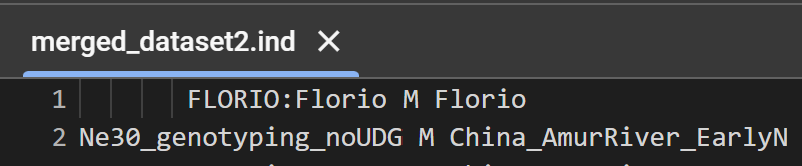

In [ ]:
# Define input parameters using markdown or comment annotations.
# Replace this with the appropriate input method if using a specific notebook interface.

# Dataset prefix
prefix = "/content/Florio_merged"  # @param {type:"string"}

# Populations (can be comma-separated string or quoted list)
left_poplist = "Tunisia_Kerkouane_Punic_oAfrica1.SG,Gambian.DG"  # @param {type:"string"}
right_poplist = "Mbuti.DG,Luxembourg_Mesolithic.AG,Turkey_Southeast_Cayonu_PPN.SG,Hungary_Langobard_o2.AG,Iran_GanjDareh_Historic.AG,Greece_Logkas_MBA.SG,USA_CA_SantaRosa_7400BP.AG"  # @param {type:"string"}
target = 'Florio'  # @param {type:"string"}

# File names for outputs
weights_file = "weights1.csv"  # @param {type:"string"}
popdrop_file = "popdrop1.csv"  # @param {type:"string"}

# Detach shinyjs option
detach_shinyjs = True  # @param {type:"boolean"}

# allsnps option
allsnps = True  # @param {type:"boolean"}

# Function to parse population lists
def parse_poplist(poplist):
    if isinstance(poplist, str):
        # Split by commas and strip whitespace/quotes
        return [pop.strip().strip("'") for pop in poplist.split(',')]
    return poplist

# Parse the population lists
left = parse_poplist(left_poplist)
right = parse_poplist(right_poplist)

import rpy2.robjects as robjects

# Pass the parameters to the R environment
robjects.globalenv['prefix'] = prefix
robjects.globalenv['left'] = robjects.StrVector(left)
robjects.globalenv['right'] = robjects.StrVector(right)
robjects.globalenv['target'] = target
robjects.globalenv['weights_file'] = weights_file
robjects.globalenv['popdrop_file'] = popdrop_file
robjects.globalenv['detach_shinyjs'] = detach_shinyjs
robjects.globalenv['allsnps'] = allsnps


In [ ]:
#@markdown **Run qpAdm (AT2)**

%%R
# Load necessary libraries
library(admixtools)
library(tidyverse)

# Retrieve the parameters passed from Python
prefix <- get("prefix", envir = .GlobalEnv)
left <- get("left", envir = .GlobalEnv)
right <- get("right", envir = .GlobalEnv)
target <- get("target", envir = .GlobalEnv)
weights_file <- get("weights_file", envir = .GlobalEnv)
popdrop_file <- get("popdrop_file", envir = .GlobalEnv)
detach_shinyjs <- get("detach_shinyjs", envir = .GlobalEnv)
allsnps <- get("allsnps", envir = .GlobalEnv)

# Detach shinyjs if specified
if (detach_shinyjs) {
  try(detach("package:shinyjs", unload=TRUE), silent=TRUE)
}

# Print the parameters to verify they are set correctly
print(paste("Prefix path: ", prefix))
print(paste("Left populations: ", toString(left)))
print(paste("Right populations: ", toString(right)))
print(paste("Target population: ", target))
print(paste("Weights file: ", weights_file))
print(paste("Popdrop file: ", popdrop_file))
print(paste("Detach shinyjs: ", detach_shinyjs))
print(paste("All SNPs: ", allsnps))

# Execute qpAdm analysis
results <- qpadm(prefix, left, right, target, allsnps = allsnps)

# Set output options for detailed viewing in the console
options(dplyr.width = Inf, max.print = 100000, digits = 10)

# Output admixture results to CSV files
write.csv(results$weights, weights_file, row.names = FALSE)
write.csv(results$popdrop, popdrop_file, row.names = FALSE)

# Print detailed results to the console
print(results$weights, n = Inf)
print(results$popdrop, n = Inf)
if ("f4" %in% names(results)) {
  print(results$f4, n = Inf)
}

# Indicate completion
print("qpAdm analysis complete. Results are also saved in CSV files.")


# **[6] AT1 qpAdm Prep and Running**

In [ ]:
#@title Prepare qpAdm Analysis Files and Create Population Lists
%cd /content/
%pwd
#@markdown Enter the name/label of the target population (first in the left file):
target_population = "Florio" #@param {type:"string"}

#@markdown Enter the names/labels of the source populations (separate by commas):
source_populations = "Tunisia_Kerkouane_Punic_oAfrica1.SG,Gambian.DG" #@param {type:"string"}

#@markdown Enter the names/labels of the reference populations (right file, separate by commas):
reference_populations = "Mbuti.DG,Luxembourg_Mesolithic.AG,Turkey_Southeast_Cayonu_PPN.SG,Hungary_Langobard_o2.AG,Iran_GanjDareh_Historic.AG,Greece_Logkas_MBA.SG,USA_CA_SantaRosa_7400BP.AG" #@param {type:"string"}

#@markdown Enter the prefix for your merged dataset files (e.g., `S1` if you have `S1.ind`, `S1.snp`, `S1.geno`):
dataset_prefix = "Florio_merged" #@param {type:"string"}

#@markdown Select YES or NO for allsnps:
allsnps = "YES" #@param ["YES", "NO"]

#@markdown Select YES or NO for inbreed:
inbreed = "NO" #@param ["YES", "NO"]

# Prepare populations lists
source_list = source_populations.split(",")
reference_list = reference_populations.split(",")

# Save left1 file
left1_content = f"{target_population}\n" + "\n".join(source_list)
with open("left1.txt", "w") as file:
    file.write(left1_content)

# Save right1 file
right1_content = "\n".join(reference_list)
with open("right1.txt", "w") as file:
    file.write(right1_content)

# Save poplist file (arranged as reference pops on top, then target, then sources)
poplist_content = "\n".join(reference_list) + f"\n{target_population}\n" + "\n".join(source_list)
with open("poplist", "w") as file:
    file.write(poplist_content)

print("Left, right, and poplist population files have been saved successfully.")


In [ ]:
#@title Create the parqpAdm File

parqpAdm_content = f"""
S1:                  {dataset_prefix}
indivname:       {dataset_prefix}.ind
snpname:         {dataset_prefix}.snp
genotypename:    {dataset_prefix}.geno
popleft:  left1.txt
popright: right1.txt
details:  YES
allsnps:  {allsnps}
inbreed:  {inbreed}
summary:  YES
"""

with open("/content/parqpAdm.txt", "w") as file:
    file.write(parqpAdm_content)

print("Parameter file for qpAdm has been created successfully.")


In [ ]:
#@title Add AdmixTools to the Environment Path and Verify
import os

# Add AdmixTools bin directory to PATH
os.environ['PATH'] += os.pathsep + "/content/AdmixTools/bin"

# Confirm qpfstats is now accessible
!which qpfstats


**Computing F-statistics allows users to calculate genetic differentation and relatedness for an entire poplist.**

## **The poplist is composed of the Target + Source + Reference populations combined**

**If you wish to try different combinatorials (e.g. swapping the Target, moving a Source to Reference or vice-versa, removing a pop, etc), please add it to Reference pop list to save yourself some time. You can always swap and remove pops from the poplist, but never add without computing f-statistics all over again.**

**To run different combinations, simply do all of Step 6 (this section) without Computing F-Statistics (the cell below), as you have already done so for the given poplist.**

In [ ]:
#@title Compute F-Statistics

parqpfstats_content = f"""
DIR: /content/
S1: {dataset_prefix}
indivname: /content/{dataset_prefix}.ind
snpname: /content/{dataset_prefix}.snp
genotypename: /content/{dataset_prefix}.geno
poplistname: poplist
fstatsoutname: fstatsa.txt
allsnps: YES
inbreed: NO
"""

with open("/content/parqpfstats.txt", "w") as file:
    file.write(parqpfstats_content)

!qpfstats -p /content/parqpfstats.txt
print("F-statistics computation completed successfully.")

In [ ]:
#@title Run qpAdm Analysis
#@markdown Enter the desired output filename (without .txt extension):
output_filename = "results3" #@param {type:"string"}

#@markdown Enter the filepath to the fstats file (if any):
fstats_filepath = "/content/fstatsa.txt" #@param {type:"string"}

#@markdown Do you want to use the precomputed fstats file?
use_fstats = True #@param {type:"boolean"}

# Modify parqpAdm.txt if fstats file is used
if use_fstats and fstats_filepath:
    with open("/content/parqpAdm.txt", "a") as file:
        file.write(f"fstatsname: {fstats_filepath}\n")

! /content/AdmixTools/bin/qpAdm -p /content/parqpAdm.txt > /content/{output_filename}.txt
print(f"qpAdm analysis completed successfully. Results saved to {output_filename}.txt")


**After running the previous code cell, your results should be in the File Explorer on the left. Double-click to open them or right-click to Download.**

# **[6b] Data Analysis and Visualization**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import numpy as np

# @title Parse and Visualize qpAdm Output
# @markdown Please paste the path to your qpAdm result file:
qpadm_results_path = "/content/results3.txt"  # @param {type:"string"}

def parse_qpadm_output(filepath):
    try:
        with open(filepath) as f:
            content = f.read()

        # Extract target population
        target_population = content.split('left pops:\n')[1].split('\n')[0].strip().rsplit(maxsplit=1)[0]

        # Extract left populations
        left_pops_raw = content.split('left pops:\n')[1].split('\n\n')[0].strip().split('\n')[1:]  # Skip target population
        left_pops = [pop.rsplit(maxsplit=1)[0] for pop in left_pops_raw]

        # Extract right populations
        right_pops_raw = content.split('right pops:\n')[1].split('\n\n')[0].strip().split('\n')
        right_pops = [pop.rsplit(maxsplit=1)[0] for pop in right_pops_raw]

        # Extract best coefficients and standard errors
        best_coeffs_raw = content.split('best coefficients:')[1].split('\n')[0].strip()
        best_coeffs = [float(bc) * 100 for bc in best_coeffs_raw.split()]  # Convert to percentages

        std_errors_raw = content.split('std. errors:')[1].split('\n')[0].strip()
        std_errors = [float(se) * 100 for se in std_errors_raw.split()]  # Convert to percentages

        # Extract chi-squared value
        chi_squared = float(content.split('chisq:')[1].split()[0])

        # Extract p-value
        p_value_line = content.split('tail:')[1].split()[0]
        p_value = float(p_value_line.strip())

        # Construct DataFrame
        df = pd.DataFrame({
            'Source Population': left_pops,
            'Admixture Proportion': best_coeffs,
            'Standard Error': std_errors,
            'Chi-Squared': [chi_squared] * len(left_pops),
            'P-Value': [p_value] * len(left_pops)
        })

        return df, target_population, right_pops

    except Exception as e:
        print(f"Error parsing the qpAdm output: {e}")
        return pd.DataFrame(), '', []

# Parse the results and check if the DataFrame is not empty
df_admixture, target_population, right_pops = parse_qpadm_output(qpadm_results_path)
if not df_admixture.empty:
    print(df_admixture)
    print("\nReference Populations Used:")
    for pop in right_pops:
        print(pop)
else:
    print("Parsed DataFrame is empty or an error was encountered.")

# @title Select Plot Type
# @markdown Choose the type of plot to display:
plot_type = "Pie Chart"  # @param ["Bar Graph", "Pie Chart"]

def wrap_text(text, width=50):
    wrapped_lines = textwrap.wrap(text, width)
    return "\n".join(wrapped_lines)

def create_plot(plot_type):
    if not df_admixture.empty:
        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

        if plot_type == "Bar Graph":
            palette = sns.color_palette("deep", len(df_admixture))
            bars = ax.bar(df_admixture['Source Population'], df_admixture['Admixture Proportion'], color=palette)

            for bar, prop, se in zip(bars, df_admixture['Admixture Proportion'], df_admixture['Standard Error']):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}% ± {se:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=8)

            ax.set_title(f'Target Population: {target_population}\nAdmixture Proportions (Chi-Squared: {df_admixture["Chi-Squared"].iloc[0]:.2f}, P-Value: {df_admixture["P-Value"].iloc[0]:.12g})', fontsize=9, fontweight='bold')
            ax.set_xlabel('Source Population', fontsize=10, fontweight='bold')
            ax.set_ylabel('Admixture Proportion (%)', fontsize=10, fontweight='bold')
            ax.tick_params(axis='x', rotation=45, labelsize=10, labelcolor='black', width=1.5, length=6, direction='out')
            ax.tick_params(axis='y', labelsize=10, labelcolor='black', width=1.5, length=6, direction='out')

            for label in ax.get_xticklabels() + ax.get_yticklabels():
                label.set_fontweight('bold')

            ax.spines['top'].set_linewidth(1.5)
            ax.spines['right'].set_linewidth(1.5)
            ax.spines['bottom'].set_linewidth(1.5)
            ax.spines['left'].set_linewidth(1.5)

            wrapped_text = wrap_text(f'Reference Populations: {", ".join(right_pops)}', width=60)
            plt.figtext(0.5, -0.05, wrapped_text, ha='center', va='top', fontsize=8)

        elif plot_type == "Pie Chart":
            if np.any(df_admixture['Admixture Proportion'] <= 0):
                print("Admixture proportions must be positive for pie charts.")
                return

            wedges, texts = ax.pie(
                df_admixture['Admixture Proportion'],
                colors=sns.color_palette("deep", len(df_admixture)),
                startangle=140,
                wedgeprops=dict(edgecolor='black', width=0.3)
            )

            # Remove pie chart labels and percentages
            for text in texts:
                text.set_text('')

            ax.legend(wedges, [f'{pop}: {prop:.2f}% ± {se:.2f}%' for pop, prop, se in zip(df_admixture['Source Population'], df_admixture['Admixture Proportion'], df_admixture['Standard Error'])], title="Admixture Proportions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10, title_fontsize='12')

            plt.figtext(0.625, 0.97, f'Target Population: {target_population}\nAdmixture Proportions (Chi-Squared: {df_admixture["Chi-Squared"].iloc[0]:.2f}, P-Value: {df_admixture["P-Value"].iloc[0]:.12g})', ha='center', va='top', fontsize=10, fontweight='bold')
            wrapped_text = wrap_text(f'Reference Populations: {", ".join(right_pops)}', width=60)
            plt.figtext(0.625, 0.03, wrapped_text, ha='center', va='top', fontsize=8)

        plt.tight_layout()
        plt.show()
    else:
        print("No data available for plotting.")

# Create the plot
create_plot(plot_type)


# **[7] Mounting Drive and Saving Compressed Files**

To avoid the lengthy merging process in the future, we can mount our Google Drive and save any intermediate files and results using the code cell below. This will create a folder called **colabadmixtools** for you. Especially the merged dataset files (i.e. the .ind, .geno, .snp files). If you would like to do analysis on your merged data again in the future, just mount your drive using and specify the path of the compressed folder (Step 1 Option 3). After you mount, your drive should be at /content/drive/MyDrive within Colab. You will still need to perform Step 1 in the future but can then skip to Step 5.

In [ ]:
# @title Mount Google Drive, Compress, and Save Files
# @markdown Please mount your Google Drive, enter a name for the zipped folder, and then enter the paths of the files you want to save, separated by commas.
zip_folder_name = "Florio_merged" #@param {type:"string"}
file_paths = "/content/Florio_merged1240K.geno,/content/Florio_merged1240K.ind,/content/Florio_merged1240K.snp,/content/Zaer_mergedHO.geno,/content/Zaer_mergedHO.ind,/content/Zaer_mergedHO.snp" #@param {type:"string"}

from google.colab import drive
import os
import zipfile

# Ensure the user has provided a zip folder name
if not zip_folder_name:
    print("Please provide a name for the zipped folder.")
else:
    # Mount Google Drive
    drive.mount('/content/drive')

    # Path for the 'colabadmixtools' folder
    new_folder_path = '/content/drive/MyDrive/colabadmixtools'
    if not os.path.exists(new_folder_path):
        os.makedirs(new_folder_path)
        print(f"Created folder: {new_folder_path}")
    else:
        print(f"Folder already exists: {new_folder_path}")

    # Define the path for the ZIP file using the user-provided name
    zip_file_path = os.path.join(new_folder_path, f"{zip_folder_name}.zip")

    # Split the user-entered file paths by commas and trim whitespace
    file_paths_list = [path.strip() for path in file_paths.split(',')]

    # Check if any file paths were entered
    if not file_paths_list or file_paths_list == ['']:
        print("No file paths entered. Please enter the paths of the files you want to save.")
    else:
        # Create a ZIP file and add the specified files
        with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for file_path in file_paths_list:
                if os.path.exists(file_path):
                    # Add file to the ZIP archive
                    zipf.write(file_path, os.path.basename(file_path))
                    print(f"Added '{file_path}' to the ZIP archive: {zip_folder_name}.zip")
                else:
                    print(f"File does not exist: {file_path}")
        print(f"Files have been successfully compressed and saved to '{zip_file_path}'")


# **Utilities**

### EIGENSTRAT/PACKEDANCESTRYMAP to PLINK Conversion ( + Extraction)

### Instructions

- **inpref**: Prefix of the input files.
- **outpref**: Desired prefix for the PLINK output files.
- **inds**: (Optional) Comma-separated list of individuals to extract. If provided, `pops` should be left empty.
- **pops**: (Optional) Comma-separated list of populations to extract. If provided, `inds` should be left empty.
- **verbose**: Choose whether to print progress updates.

Ensure that you provide either `inds` or `pops`, but not both if extracting. WARNING: Conversion of very large datasets is not possible in the Colab runtime (as of now) - please try converting/extracting the populations (Group Labels/IDs) you deem necessary for further analysis to avoid crashing the runtime.


In [ ]:
# Define input parameters using Colab's form fields

# Prefix of the input files
inpref = "/content/Florio_merged"  # @param {type:"string"}

# Prefix of the PLINK output files
outpref = "/content/Test3"  # @param {type:"string"}

# Individuals to extract (comma-separated string)
inds = ""  # @param {type:"string"}

# Populations to extract (comma-separated string)
pops = "Florio,IBS.DG,Surui.DG"  # @param {type:"string"}

# Verbose option
verbose = True  # @param {type:"boolean"}

# Function to parse lists
def parse_list(input_list):
    if isinstance(input_list, str) and input_list:
        # Split by commas and strip whitespace
        return [item.strip() for item in input_list.split(',')]
    return None

# Parse the individuals and populations lists
inds_list = parse_list(inds)
pops_list = parse_list(pops)

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

# Activate the automatic conversion of pandas objects to R objects
pandas2ri.activate()

# Pass the parameters to the R environment
robjects.globalenv['inpref'] = inpref
robjects.globalenv['outpref'] = outpref
robjects.globalenv['inds'] = robjects.StrVector(inds_list) if inds_list else robjects.NULL
robjects.globalenv['pops'] = robjects.StrVector(pops_list) if pops_list else robjects.NULL
robjects.globalenv['verbose'] = verbose

# Load necessary libraries and run the conversion
robjects.r('''
# Load necessary libraries
library(admixtools)

# Retrieve the parameters passed from Python
inpref <- get("inpref", envir = .GlobalEnv)
outpref <- get("outpref", envir = .GlobalEnv)
inds <- get("inds", envir = .GlobalEnv)
pops <- get("pops", envir = .GlobalEnv)
verbose <- get("verbose", envir = .GlobalEnv)

# Print the parameters to verify they are set correctly
print(paste("Input prefix: ", inpref))
print(paste("Output prefix: ", outpref))
print(paste("Individuals: ", if (is.null(inds)) "None" else toString(inds)))
print(paste("Populations: ", if (is.null(pops)) "None" else toString(pops)))
print(paste("Verbose: ", verbose))

# Run the conversion
packedancestrymap_to_plink(
  inpref = inpref,
  outpref = outpref,
  inds = inds,
  pops = pops,
  verbose = verbose
)

# Indicate completion
print("Conversion complete. PLINK files are saved with the specified prefix.")
''')


### **PLINK to 23andMe Conversion (PLINK)**

### Instructions

- **plink_file**: Prefix of the PLINK input files without the extension.
- **individual_id**: ID of the individual to be converted to 23andMe format.

Ensure that the PLINK input files (.bed, .bim, .fam) are in the specified directory.


In [ ]:
import os
import subprocess
import pandas as pd

# Check if PLINK is already downloaded
if not os.path.isfile('plink'):
    # Download PLINK
    !wget --no-check-certificate https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20231211.zip
    !unzip plink_linux_x86_64_20231211.zip
    !chmod +x plink
else:
    print("PLINK is already downloaded. Skipping download step.")

# Define input parameters using Colab's form fields

# Prefix of the PLINK input files without the extension
plink_file = "/content/Test3"  # @param {type:"string"}

# ID of the individual to be converted to 23andMe format
individual_id = "Florio:Florio"  # @param {type:"string"}

# Read the .fam file to get family and individual IDs
fam_file = f"{plink_file}.fam"
fam_df = pd.read_csv(fam_file, delim_whitespace=True, header=None)

# Check if the individual ID exists in the .fam file
if individual_id not in fam_df[1].values:
    raise ValueError(f"Individual ID {individual_id} not found in {fam_file}.")

# Create filter.txt for the specified individual
filter_txt_content = fam_df[fam_df[1] == individual_id][[0, 1]].to_string(header=False, index=False)
with open("filter.txt", "w") as file:
    file.write(filter_txt_content)

# Run PLINK command to convert to 23andMe format
plink_command = f"./plink --bfile {plink_file} --keep filter.txt --snps-only --recode 23 --out {individual_id}"
subprocess.run(plink_command, shell=True)

# Clean up
os.remove("filter.txt")

# Print the PLINK log file
log_file = f"{individual_id}.log"
if os.path.isfile(log_file):
    with open(log_file, 'r') as file:
        print("PLINK Log File:")
        print(file.read())

# Determine the correct 23andMe format file
possible_files = [f for f in os.listdir() if f.startswith(individual_id) and f.endswith('.txt')]
if possible_files:
    final_txt_file = possible_files[0]
    print(f"\nFirst 15 lines of the 23andMe format file ({final_txt_file}):")
    with open(final_txt_file, 'r') as file:
        for _ in range(15):
            print(file.readline().strip())
else:
    print(f"23andMe format file for {individual_id} not found.")


### **PCA or MDS Plot Creation (PLINK)**

### Instructions

- **plink_file**: Prefix of the PLINK input files without the extension.
- **method**: Choose between 'pca' and 'mds' for the analysis.
- **count**: Number of dimensions to extract (for MDS) or principal components to extract (for PCA).


In [ ]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check if PLINK is already downloaded
if not os.path.isfile('plink'):
    # Download PLINK
    !wget --no-check-certificate https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20231211.zip
    !unzip plink_linux_x86_64_20231211.zip
    !chmod +x plink
else:
    print("PLINK is already downloaded. Skipping download step.")

# Define input parameters using Colab's form fields

# Prefix of the PLINK input files without the extension
plink_file = "/content/Test3"  # @param {type:"string"}

# Choose between 'pca' and 'mds' for the analysis
method = "pca"  # @param ["pca", "mds"]

# Number of dimensions to extract (for MDS) or principal components to extract (for PCA)
count = 25  # @param {type:"number"}

# Figure size for the plot
figsize_width = 27  # @param {type:"slider", min:5, max:50, step:1}
figsize_height = 25  # @param {type:"slider", min:5, max:50, step:1}

# Run PLINK command for PCA or MDS analysis
if method == "pca":
    plink_command = f"./plink --bfile {plink_file} --pca {count} header tabs --out {plink_file}"
    subprocess.run(plink_command, shell=True)
    eigenvec_file = f"{plink_file}.eigenvec"
    eigenval_file = f"{plink_file}.eigenval"

    # Read the eigenvec file
    eigenvec_df = pd.read_csv(eigenvec_file, delim_whitespace=True)

    # Plot PCA
    plt.figure(figsize=(figsize_width, figsize_height), dpi=300)
    sns.scatterplot(x=eigenvec_df.iloc[:, 2], y=eigenvec_df.iloc[:, 3], hue=eigenvec_df.iloc[:, 1], palette='deep', legend=False)

    # Add sample labels
    for i in range(len(eigenvec_df)):
        plt.text(eigenvec_df.iloc[i, 2], eigenvec_df.iloc[i, 3], eigenvec_df.iloc[i, 1],
                 fontsize=9, weight='bold', ha='right' if eigenvec_df.iloc[i, 2] > 0 else 'left',
                 va='bottom' if eigenvec_df.iloc[i, 3] > 0 else 'top')

    plt.title('PCA Plot', fontsize=16)
    plt.xlabel('PC1', fontsize=14)
    plt.ylabel('PC2', fontsize=14)
    plt.show()

    # Print the PCA data table of eigenvectors
    print("Table of Eigenvectors:")
    display(eigenvec_df)

elif method == "mds":
    plink_command = f"./plink --bfile {plink_file} --cluster --mds-plot {count} eigvals --out {plink_file}"
    subprocess.run(plink_command, shell=True)
    mds_file = f"{plink_file}.mds"

    # Read the mds file
    mds_df = pd.read_csv(mds_file, delim_whitespace=True)

    # Plot MDS
    plt.figure(figsize=(figsize_width, figsize_height), dpi=300)
    sns.scatterplot(x=mds_df.iloc[:, 3], y=mds_df.iloc[:, 4], hue=mds_df.iloc[:, 1], palette='deep', legend=False)

    # Add sample labels
    for i in range(len(mds_df)):
        plt.text(mds_df.iloc[i, 3], mds_df.iloc[i, 4], mds_df.iloc[i, 1],
                 fontsize=9, weight='bold', ha='right' if mds_df.iloc[i, 3] > 0 else 'left',
                 va='bottom' if mds_df.iloc[i, 4] > 0 else 'top')

    plt.title('MDS Plot', fontsize=16)
    plt.xlabel('Dimension 1', fontsize=14)
    plt.ylabel('Dimension 2', fontsize=14)
    plt.show()

    # Print the MDS data table
    print("MDS Data Table:")
    display(mds_df)

else:
    raise ValueError("Invalid method selected. Choose either 'pca' or 'mds'.")


## **Compute Fst (AT2)**

In [ ]:
#@markdown **Input Parameters for Fst Computation**

# Dataset prefix
prefix = "/content/Florio_merged"  # @param {type:"string"}

# Population 1 (comma-separated population labels or file path)
pop1_input = "Florio,Tunisia_Kerkouane_Punic_oAfrica1.SG,Gambian.DG"  # @param {type:"string"}

# Population 2 (comma-separated population labels or file path)
pop2_input = "Mbuti.DG,Luxembourg_Mesolithic.AG,MXL.DG,Turkey_Southeast_Cayonu_PPN.SG,Hungary_Langobard_o2.AG,Iran_GanjDareh_Historic.AG,Greece_Logkas_MBA.SG,USA_CA_SantaRosa_7400BP.AG"  # @param {type:"string"}

# Use bootstrapping? (If FALSE, block-jackknife resampling will be used)
boot = False  # @param {type:"boolean"}

# Adjust pseudohaploid (set to False if you have pseudohaploid samples)
adjust_pseudohaploid = False  # @param {type:"boolean"}

# Function to parse population lists
def parse_poplist(poplist):
    if isinstance(poplist, str):
        # Split by commas and strip whitespace/quotes
        return [pop.strip().strip("'") for pop in poplist.split(',')]
    return poplist

# Parse the population lists
pop1 = parse_poplist(pop1_input)
pop2 = parse_poplist(pop2_input)

# Import rpy2 for interfacing with R
import rpy2.robjects as robjects

# Pass the parameters to the R environment
robjects.globalenv['prefix'] = prefix
robjects.globalenv['pop1'] = robjects.StrVector(pop1)
robjects.globalenv['pop2'] = robjects.StrVector(pop2)
robjects.globalenv['boot'] = boot
robjects.globalenv['adjust_pseudohaploid'] = adjust_pseudohaploid

print("Input parameters set:")
print(f"Dataset prefix: {prefix}")
print(f"Population 1: {pop1}")
print(f"Population 2: {pop2}")
print(f"Bootstrapping: {boot}")
print(f"Adjust pseudohaploid: {adjust_pseudohaploid}")


In [ ]:
#@markdown **Run Fst Computation**

%%R
# Load necessary libraries
library(admixtools)
library(tidyverse)

# Retrieve parameters from Python
prefix <- get("prefix", envir = .GlobalEnv)
pop1 <- get("pop1", envir = .GlobalEnv)
pop2 <- get("pop2", envir = .GlobalEnv)
boot <- get("boot", envir = .GlobalEnv)
adjust_pseudohaploid <- get("adjust_pseudohaploid", envir = .GlobalEnv)

# Print parameters for verification
cat("Prefix path:", prefix, "\n")
cat("Population 1:", toString(pop1), "\n")
cat("Population 2:", toString(pop2), "\n")
cat("Bootstrapping:", boot, "\n")
cat("Adjust pseudohaploid:", adjust_pseudohaploid, "\n")

# Compute Fst directly from genotype files
fst_results <- fst(
  data = prefix,
  pop1 = pop1,
  pop2 = pop2,
  boot = boot,
  verbose = TRUE,
  adjust_pseudohaploid = adjust_pseudohaploid
)

# Output Fst results
print("Fst computation complete.")
print(fst_results, n = Inf)  # Ensures all rows are displayed

# Save results to a CSV file for convenience
write.csv(fst_results, "fst_results.csv", row.names = FALSE)

cat("Fst results saved to fst_results.csv.\n")


### **Admixture Graphs (AT2)**

In [ ]:
#@markdown **Admixture Graph Input Parameters**

# Dataset prefix for f-statistics
prefix = "/content/Florio_merged"  # @param {type:"string"}

# Populations for admixture graph (comma-separated or user input)
populations_input = "Florio,Tunisia_Kerkouane_Punic_oAfrica1.SG,Gambian.DG,Mbuti.DG"  # @param {type:"string"}

# Number of admixture edges for find_graphs
numadmix = 3  # @param {type:"integer"}

# Output population for graph root
outpop = "Mbuti.DG"  # @param {type:"string"}

# Stop generation for find_graphs
stop_gen = 25  # @param {type:"integer"}

# Function to parse the population list
def parse_poplist(poplist):
    if isinstance(poplist, str):
        return [pop.strip() for pop in poplist.split(",")]
    return poplist

# Parse user-specified populations
populations = parse_poplist(populations_input)

# Pass parameters to R environment
import rpy2.robjects as robjects

robjects.globalenv['prefix'] = prefix
robjects.globalenv['populations'] = robjects.StrVector(populations)
robjects.globalenv['numadmix'] = numadmix
robjects.globalenv['outpop'] = outpop
robjects.globalenv['stop_gen'] = stop_gen

print("Input parameters set:")
print(f"Prefix: {prefix}")
print(f"Populations: {populations}")
print(f"Number of admixture edges: {numadmix}")
print(f"Outgroup population: {outpop}")
print(f"Stop generation: {stop_gen}")


In [ ]:
#@markdown **Run Admixture Graph Analysis**

%%R
library(admixtools)
library(tidyverse)
library(plotly)

# Retrieve parameters
prefix <- get("prefix", envir = globalenv())
populations <- get("populations", envir = globalenv())
numadmix <- get("numadmix", envir = globalenv())
outpop <- get("outpop", envir = globalenv())
stop_gen <- get("stop_gen", envir = globalenv())

# Print parameters for verification
cat("Prefix path:", prefix, "\n")
cat("Populations:", toString(populations), "\n")
cat("Number of admixture edges:", numadmix, "\n")
cat("Outgroup population:", outpop, "\n")
cat("Stop generation:", stop_gen, "\n")

# Compute f2 blocks from the dataset
cat("Computing f2 blocks...\n")
f2_blocks <- f2_from_geno(prefix, pops = populations)

# Automated graph exploration
cat("Finding optimal graphs...\n")
opt_results <- find_graphs(f2_blocks, numadmix = numadmix, outpop = outpop, stop_gen = stop_gen)

# Extract the best graph
winner <- opt_results %>% slice_min(score, with_ties = FALSE)

# Display best graph score
best_score <- winner$score[[1]]
cat("Best graph score:", best_score, "\n")

# Plot the best graph interactively
cat("Visualizing the best graph...\n")
best_graph <- winner$edges[[1]]

# Use plotly to create and display an interactive graph
interactive_plot <- plotly_graph(best_graph, fix = TRUE)

# Save the graph edges and scores
write.csv(best_graph, "best_graph_edges.csv", row.names = FALSE)
cat("Best graph edges saved to best_graph_edges.csv.\n")

# Output the plot for Jupyter Notebook
interactive_plot


In [ ]:
# Import necessary libraries
import os
import sys
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

# Function to check and install required packages
def install_and_import(package_name, package_alias=None):
    try:
        __import__(package_alias or package_name)
    except ImportError:
        print(f"Package '{package_name}' not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])

# Ensure required packages are installed
install_and_import("python-igraph", "igraph")
install_and_import("matplotlib")

# Import igraph after ensuring it is installed
from igraph import Graph, plot

# Define custom parameters as form fields
# Path to the graph file (CSV)
graph_file = "best_graph_edges.csv"  # @param {type:"string"}

# Edge width for connections
edge_width = 2  # @param {type:"slider", min:0.5, max:10, step:0.1}

# Font size for node labels
font_size = 8  # @param {type:"slider", min:8, max:40, step:1}

# Layout type (options: "tree" or "kk")
layout_type = "tree"  # @param ["tree", "kk"]

# Round percentages to this number of decimal places
decimal_places = 1  # @param {type:"slider", min:0, max:3, step:1}

# Plot dimensions
plot_width = 20  # @param {type:"slider", min:10, max:100, step:1}
plot_height = 12  # @param {type:"slider", min:10, max:100, step:1}

# Background color
background_color = "white"  # @param ["white", "lightgray", "black"]

# Edge color
edge_color = "darkgray"  # @param ["darkgray", "black", "blue", "red"]

# Text color
text_color = "black"  # @param ["black", "white", "blue", "red"]

# Function to plot the admixture graph
def plot_admixture_graph(graph_file, edge_width, font_size, layout_type, decimal_places, plot_width, plot_height, background_color, edge_color, text_color):
    if not os.path.isfile(graph_file):
        print(f"Error: File '{graph_file}' not found.")
        return

    # Load edges from CSV
    edges_df = pd.read_csv(graph_file)

    # Create igraph object
    g = Graph(directed=True)
    g.add_vertices(list(set(edges_df["from"].tolist() + edges_df["to"].tolist())))
    g.add_edges(zip(edges_df["from"], edges_df["to"]))

    # Set layout
    if layout_type == "tree":
        layout = g.layout("rt")
    else:
        layout = g.layout("kk")

    # Prepare vertex labels with rounded contributions
    vertex_labels = []
    for vertex in g.vs:
        if vertex["name"] in edges_df["to"].values:
            contribution = edges_df[edges_df["to"] == vertex["name"]][["from", "weight"]]
            contribution["weight"] = contribution["weight"].apply(lambda x: round(x * 100, decimal_places))  # Round
            label = f"{vertex['name']} ({', '.join(contribution['from'] + ': ' + contribution['weight'].astype(str) + '%')})"
            vertex_labels.append(label)
        else:
            vertex_labels.append(vertex["name"])

    # Dynamically calculate figure size based on layout
    layout_coords = layout.coords  # Extract the coordinates
    x_coords = [coord[0] for coord in layout_coords]
    y_coords = [coord[1] for coord in layout_coords]
    dynamic_width = max(x_coords) - min(x_coords)
    dynamic_height = max(y_coords) - min(y_coords)
    fig_width = max(dynamic_width / 2, plot_width)  # Scale width appropriately
    fig_height = max(dynamic_height / 2, plot_height)  # Scale height appropriately

    # Plot the graph
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.set_facecolor(background_color)  # Set background color
    plot(
        g,
        layout=layout,
        target=ax,
        vertex_size=0,  # No default circles
        vertex_label=vertex_labels,
        vertex_label_size=font_size,
        vertex_label_dist=0.5,  # Increase label distance from nodes
        vertex_label_color=text_color,  # Set text color
        vertex_label_fontweight="bold",  # Bold text
        edge_width=edge_width,
        edge_color=edge_color,
        bbox=None,  # Autoscale the graph
        margin=max(dynamic_height / 10, 10),  # Dynamic margin
    )
    plt.title("Admixture Graph with Contributions", fontsize=font_size + 4, fontweight="bold", color=text_color)
    plt.tight_layout()
    plt.show()

# Call the plotting function with user-defined parameters
plot_admixture_graph(
    graph_file,
    edge_width,
    font_size,
    layout_type,
    decimal_places,
    plot_width,
    plot_height,
    background_color,
    edge_color,
    text_color
)
